In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score


In [2]:
#Load Data

df = pd.read_table('finalDataSetYork.csv',
                   sep=',', encoding='ISO-8859-1', names = ["word", "sentiment"])
df["word"] = df["word"].str.lower()
df = df.drop_duplicates(subset=['word'])

In [4]:
# Load the whole embedding matrix
embeddings_index = {}
f=open('glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    
    embed = np.array(values[1:])
    embed = ','.join(embed)
    embed = np.fromstring( embed, dtype=np.float, sep=',' )
    #print(embed)
    #dtype=np.float32
    #numpy. ndarray. astype(dtype)
    embeddings_index[word] = embed
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 2195884 word vectors.


In [5]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['category_encoded'] = labelencoder.fit_transform(df['sentiment'])
category_df = pd.DataFrame(df['sentiment'].unique(), columns=['sentiment'])
category_df['emotion_category'] = labelencoder.fit_transform(category_df['sentiment'])
category_df

,sentiment,emotion_category
0,Angry,0
1,Anxiety/Stress,1
2,Fearful,2
3,Happy,3
4,Mixed/Unsure,4
5,Neutral,5
6,Other,6
7,Peaceful,7
8,Physical,8
9,Sad,9


In [6]:
words = df['word'].tolist()
categories = df['category_encoded'].tolist()

In [7]:
import numpy
# Embeddings for available words
data_embeddings ={}
unknown_words =[]
count= 0
for word in df["word"].tolist():
    if(word.lower() in embeddings_index.keys()):
        count = count +1
        if(word.lower() not in data_embeddings.keys()):
            data_embeddings[word.lower()] = numpy.append(embeddings_index[word.lower()], df[df["word"] == word]['category_encoded'].values[0], axis=None)
        else:
          print(word.lower())
    else:
        unknown_words.append(word)
data_embed_values = list(data_embeddings.values())

In [7]:
import pickle

with open('data_embedding.pickle', 'wb') as handle:
    pickle.dump(data_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('embeddings_index.pickle', 'wb') as handle:
    pickle.dump(embeddings_index, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [8]:
import pickle
with open('data_embedding.pickle', 'rb') as handle:
   data_embeddings = pickle.load(handle)

with open('embeddings_index.pickle', 'rb') as handle:
    embeddings_index = pickle.load(handle)


In [8]:
encoded_category_list = df['category_encoded'].tolist()

In [9]:
## from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_embed_values, encoded_category_list, test_size=0.2,
                                                                                random_state=40)

Minimum error:- 0.1111111111111111 at K = 7


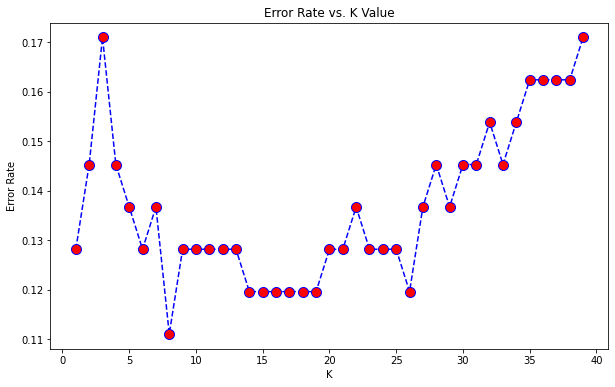

In [10]:
#Calculate K Value with Minimum Error
from sklearn.neighbors import KNeighborsClassifier
error_rate = []
for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Maximum accuracy:- 0.8888888888888888 at K = 7


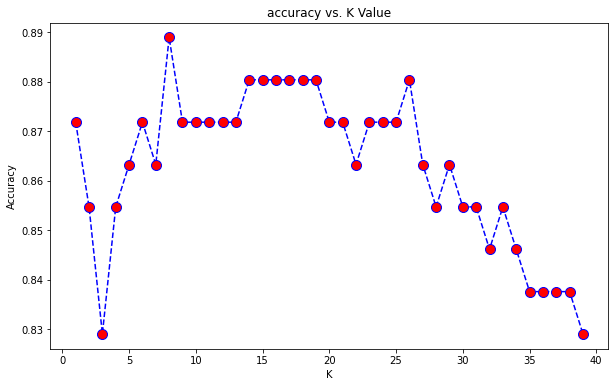

In [11]:
#Calculate K Value with Maximum Accuracy 
acc = []
# Will take some time
from sklearn import metrics
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [43]:
# Example of getting neighbors for an instance
from math import sqrt
 
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

In [79]:
def cosine_distance(a, b):
    a = a[:-1]
    b = b[:-1]
    if len(a) != len(b):
        print("a and b must be same length") 
    numerator = 0
    denoma = 0
    denomb = 0
    for i in range(len(a)):       #Mike's optimizations:
        ai = a[i]             #only calculate once
        bi = b[i]
        numerator += ai*bi    #faster than exponent (barely)
        denoma += ai*ai       #strip abs() since it's squaring
        denomb += bi*bi
    result = 1 - numerator / (sqrt(denoma)*sqrt(denomb))
    return result

In [80]:
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		dist = cosine_distance(test_row, train_row)
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors

In [81]:
X_train = X_train[:-1]
type(X_train)

list

In [82]:

neighbors = get_neighbors(X_train, X_train[0], 4)


In [83]:
# Make a classification prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	neighbors = get_neighbors(train, test_row, num_neighbors)
	output_values = [row[-1] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	return prediction

In [84]:
#Method to get predictions for KNN
predictions = []
for word in data_embed_values:
    category = predict_classification(data_embed_values, word, 4)
    predictions.append(int(category))
    
    

In [85]:
#adding to zip List
zip_List = list(zip(words, categories, predictions))
zip_List2 = list(zip(zip_List, predictions))

In [86]:
#Output in an XLS
df_new = pd.DataFrame(zip_List, columns =['word', 'sentiment', 'prediction'])
df_new
df_new.to_excel("output_CheckIn_withEucledianDist_glove_840B_300d_finalDataSetYork_KNN_cosine.xlsx") 

In [87]:
#Confusion Matrix
from sklearn import metrics
cm = metrics.confusion_matrix(categories, predictions)
pd.DataFrame(
    cm,
    index=[['actual', 'actual','actual','actual','actual','actual','actual', 'actual', 'actual','actual','actual','actual'], ['Angry', 'Anxiety/Stress', 'Fearful', 'Happy', 'Mixed/Unsure', 'Neutral', 'Other', 'Peaceful', 'Physical', 'Sad', 'Sleep', 'unknown']],
    columns=[['predicted', 'predicted','predicted','predicted','predicted','predicted','predicted', 'predicted', 'predicted','predicted','predicted','predicted'], ['Angry', 'Anxiety/Stress', 'Fearful', 'Happy', 'Mixed/Unsure', 'Neutral', 'Other', 'Peaceful', 'Physical', 'Sad', 'Sleep', 'unknown']]
)

predicted                                            \
                          Angry Anxiety/Stress Fearful Happy Mixed/Unsure   
actual Angry                 87              0       2     2            0   
       Anxiety/Stress         2              7       1     0            0   
       Fearful                5              0      24     0            0   
       Happy                  2              0       1   103            0   
       Mixed/Unsure           1              1       0     1            3   
       Neutral                4              0       0     2            0   
       Other                 17              1       3    16            0   
       Peaceful               1              0       0     4            0   
       Physical               0              0       0     1            0   
       Sad                   12              0       1     0            0   
       Sleep                  0              0       0     0            1   
       unknown                0              0       0     0            0   

                                                                         
                      Neutral Other Peaceful Physical Sad Sleep unknown  
actual Angry                1     6        0        0   7     0       0  
       Anxiety/Stress       0     0        0        0   0     0       0  
       Fearful              0     1        0        0   7     0       0  
       Happy                1     8        0        0   2     0       0  
       Mixed/Unsure         0     0        0        0   3     1       0  
       Neutral              6     1        0        0   3     0       0  
       Other                2    89        1        2  15     0       0  
       Peaceful             0     1        4        1   0     0       0  
       Physical             0     0        0       10   1     0       0  
       Sad                  0     2        0        1  95     0       0  
       Sleep                0     0        0        1   2     3       0  
       unknown              0     0        0        0   1     0       0

In [88]:
# k-nearest neighbors on the Dataset
from random import seed
from random import randrange
from csv import reader
from math import sqrt

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Find the min and max values for each column
def dataset_minmax(dataset):
	minmax = list()
	for i in range(len(dataset[0])):
		col_values = [row[i] for row in dataset]
		value_min = min(col_values)
		value_max = max(col_values)
		minmax.append([value_min, value_max])
	return minmax

# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for _ in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)





# kNN Algorithm
def k_nearest_neighbors(train, test, num_neighbors):
	predictions = list()
	for row in test:
		output = predict_classification(train, row, num_neighbors)
		predictions.append(output)
	return(predictions)

# Test the kNN on the Iris Flowers dataset

In [22]:
# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
    distances = list()
    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    if len(distances) !=0 :
        for i in range(num_neighbors):
            neighbors.append(distances[i][0])
    return neighbors

# Make a prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
    neighbors = get_neighbors(train, test_row, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    if len(output_values) !=0 :
        prediction = max(set(output_values), key=output_values.count)
    else :
        prediction = 11
    return prediction

In [89]:
#Accuracy/Precision/Recall/F1
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [91]:
accuracy, precision, recall, f1 = get_metrics(categories, predictions)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.739, precision = 0.747, recall = 0.739, f1 = 0.731


In [25]:
#Testing
prediction = predict_classification(data_embed_values, embeddings_index['victory'], 4)
category_df[category_df['emotion_category'] == prediction]['sentiment'].values[0]


'Sad'